In [1]:
"""
Intra-Chain C-C, C-G, and G-G Contact Analysis Script for Submission

Author: Qin Zhang
Created: 2025-06-11
Last Modified: 2025-06-11
License: MIT License

This script analyzes intra-chain C-C, C-G, and G-G contacts in RNA systems under varying salt concentrations.

"""
# %% Cell 1: Data Configuration and Analysis
import MDAnalysis as mda
import numpy as np
import pickle
import matplotlib.pyplot as plt
from MDAnalysis.analysis import distances
import os
from tqdm import tqdm

"""
Define file paths for RNA systems (3xG4C2 and 5xG4C2) under different salt conditions.
Data source: Zenodo repository (DOI: 10.5281/zenodo.15608685)
"""
conditions_3x = {
    "neutral":   "/media/qzhang04/3xG4C2/zenodo/A_3xG4C2_800uM_12_Na_neutral/lake_10us/",
    "17mMNaCl":  "/media/qzhang04/3xG4C2/zenodo/A_3xG4C2_800uM_12_17mMNaCl_10mMMgCl2/lake_10us/",
    "35mMNaCl":  "/media/qzhang04/3xG4C2/zenodo/A_3xG4C2_800uM_12_35mMNaCl_21mMMgCl2/lake_10us/",
    "70mMNaCl":  "/media/qzhang04/3xG4C2/zenodo/A_3xG4C2_800uM_12_70mMNaCl_42mMMgCl2/lake_10us/",
    "139mMNaCl": "/media/qzhang04/3xG4C2/zenodo/A_3xG4C2_800uM_12_139mMNaCl_83mMMgCl2/lake_10us/",
    "278mMNaCl": "/media/qzhang04/3xG4C2/zenodo/A_3xG4C2_800uM_12_278mMNaCl_167mMMgCl2/lake_10us/",
    "487mMNaCl": "/media/qzhang04/3xG4C2/zenodo/A_3xG4C2_800uM_12_487mMNaCl_292mMMgCl2/lake_10us/",
    "696mMNaCl": "/media/qzhang04/3xG4C2/zenodo/A_3xG4C2_800uM_12_696mMNaCl_417mMMgCl2/lake_10us/"
}
conditions_5x = {
    "neutral":   "/media/qzhang04/3xG4C2/zenodo/B_5xG4C2_800uM_12_Na_neutral/lake_10us/",
    "17mMNaCl":  "/media/qzhang04/3xG4C2/zenodo/B_5xG4C2_800uM_12_17mMNaCl_10mMMgCl2/lake_10us/",
    "35mMNaCl":  "/media/qzhang04/3xG4C2/zenodo/B_5xG4C2_800uM_12_35mMNaCl_21mMMgCl2/lake_10us/",
    "70mMNaCl":  "/media/qzhang04/3xG4C2/zenodo/B_5xG4C2_800uM_12_70mMNaCl_42mMMgCl2/lake_10us/",
    "139mMNaCl": "/media/qzhang04/3xG4C2/zenodo/B_5xG4C2_800uM_12_139mMNaCl_83mMMgCl2/lake_10us/",
    "278mMNaCl": "/media/qzhang04/3xG4C2/zenodo/B_5xG4C2_800uM_12_278mMNaCl_167mMMgCl2/lake_10us/",
    "487mMNaCl": "/media/qzhang04/3xG4C2/zenodo/B_5xG4C2_800uM_12_487mMNaCl_292mMMgCl2/lake_10us/",
    "696mMNaCl": "/media/qzhang04/3xG4C2/zenodo/B_5xG4C2_800uM_12_696mMNaCl_417mMMgCl2/lake_10us/"
}
"""
Define chain index ranges for 5xG4C2 system.
Each chain is represented as a slice object for atom selection.
"""
chains_5x = {
    "ch1": slice(0, 359),
    "ch2": slice(360, 719),
    "ch3": slice(720, 1079),
    "ch4": slice(1080, 1439),
    "ch5": slice(1440, 1799),
    "ch6": slice(1800, 2159),
    "ch7": slice(2160, 2519),
    "ch8": slice(2520, 2879),
    "ch9": slice(2880, 3239),
    "ch10": slice(3240, 3599),
    "ch11": slice(3600, 3959),
    "ch12": slice(3960, 4319)
}
"""
System configuration dictionary:
- chains: Atom index slices for each RNA chain
- conditions: Paths to simulation data under different salt conditions
- color: Color mapping for contact types in plots
"""

SYSTEMS = {
    '3xG4C2': {
        'chains': {f"ch{i}": slice(i*216, (i+1)*216) for i in range(12)},  
        'conditions': conditions_3x,
        'color': {'CC': '#1f77b4', 'CG': '#ff7f0e', 'GG': '#2ca02c'}
    },
    '5xG4C2': {
        'chains': chains_5x,
        'conditions': conditions_5x,
        'color': {'CC': '#aec7e8', 'CG': '#ffbb78', 'GG': '#98df8a'}
    }
}
# Parameters
SALT_CONCENTRATIONS = [0, 17, 35, 70, 139, 278, 487, 696]  # mM NaCl
REPLICAS = ['C1', 'C2', 'C3', 'C4']  # Simulation replicas
CONTACT_TYPES = ['CC', 'CG', 'GG']  # Contact types (C-C, C-G, G-G)

def analyze_system(system_config, condition_path, system_name, cond_name):
    """
    Analyze intra-chain contacts for a specific system and salt condition.
    
    Parameters:
        system_config (dict): System configuration (chains, colors, etc.)
        condition_path (str): Path to simulation data for the condition
        system_name (str): System identifier (e.g., '3xG4C2')
        cond_name (str): Condition name (e.g., '487mMNaCl')
        
    Returns:
        dict: Global mean and standard deviation of intra-chain contacts
    """
    replica_means = {ct: [] for ct in CONTACT_TYPES}
    
    print(f"\n======= system: {system_name} | condition: {cond_name} =======")
    
    for replica in REPLICAS:
        gro_path = os.path.join(condition_path, replica, "RNA.gro")
        xtc_path = os.path.join(condition_path, replica, "RNA_clusterRNA.xtc")

        # Skip if files do not exist
        if not os.path.exists(gro_path) and os.path.exists(xtc_path):
            print(f"Warning: Skipping replica {replica} (file does not exist)")
            continue
            
        u = mda.Universe(gro_path, xtc_path)
        results = {ct: [] for ct in CONTACT_TYPES}    # Store contact counts per frame

        # Prepare chain data with C and G residue selections
        chains = {}
        for chain_name, slc in system_config['chains'].items():
            chain = u.atoms[slc]
            C = chain.select_atoms("resname RC and name SC3")  # C residue SC3 atoms
            G = chain.select_atoms("resname RG and name SC3")  # G residue SC3 atoms
            chains[chain_name] = {"C": C, "G": G}
        
        # Analyze every 50th frame for efficiency
        for ts in u.trajectory[::50]:
            contact_counts = {"CC": 0, "CG": 0, "GG": 0}
            
            # Calculate intra-chain contacts
            for chain in chains.values():
                C = chain["C"]
                G = chain["G"]
             
                # C-C contacts within the same chain
                if len(C) >= 2:
                    dist = distances.self_distance_array(C.positions, box=ts.dimensions)
                    contact_counts["CC"] += np.sum(dist < 6) ## please change dist < 9 to have figureS3a in manuscript
                
                # C-G contacts within the same chain
                if len(C) >= 1 and len(G) >= 1:
                    dist = distances.distance_array(C.positions, G.positions, box=ts.dimensions)
                    contact_counts["CG"] += np.sum(dist < 6) ## please change dist < 9 to have figureS3a in manuscript
                
                # G-G contacts within the same chain
                if len(G) >= 2:
                    dist = distances.self_distance_array(G.positions, box=ts.dimensions)
                    contact_counts["GG"] += np.sum(dist < 6) ## please change dist < 9 to have figureS3a in manuscript

            # Store contact counts for this frame
            for ct in CONTACT_TYPES:
                results[ct].append(contact_counts[ct])

        # Calculate and store replica mean
        for ct in CONTACT_TYPES:
            rep_mean = np.mean(results[ct]) if results[ct] else np.nan
            replica_means[ct].append(rep_mean)
            print(f"  replica {replica} | Average number of {ct} contacts: {rep_mean:.2f}")

    # Calculate global statistics
    stats = {}
    for ct in CONTACT_TYPES:
        rep_means = np.array(replica_means[ct])
        valid_means = rep_means[~np.isnan(rep_means)]
        n_replicas = len(valid_means)
        
        if n_replicas == 0:
            global_mean = np.nan
            sd = np.nan
        else:
            global_mean = np.mean(valid_means)
            # Standard deviation with Bessel's correction (n-1)
            if n_replicas > 1:
                sd = np.std(valid_means, ddof=1)
            else:
                sd = 0.0 # When there is only one copy, SD=0
        
        stats[ct] = (global_mean, sd)
        print(f"  **{ct} statistics** global mean: {global_mean:.2f} | SD: {sd:.2f} | replicas: {n_replicas}")
    
    print("="*50)
    return stats

# Execute analysis for all systems and conditions
full_results = {}
for system_name in SYSTEMS:
    full_results[system_name] = {}
    for cond_name, cond_path in SYSTEMS[system_name]['conditions'].items():
        salt = int(cond_name.replace('mMNaCl', '')) if 'mMNaCl' in cond_name else 0
        full_results[system_name][salt] = analyze_system(
            SYSTEMS[system_name], 
            cond_path, 
            system_name, 
            cond_name
        )

# Save results for future use
with open('35_intra_CCCGG_contacts.pkl', 'wb') as f:
    pickle.dump(full_results, f)



======= system: 3xG4C2 | condition: neutral =======
  replica C1 | Average number of CC contacts: 19.62
  replica C1 | Average number of CG contacts: 73.53
  replica C1 | Average number of GG contacts: 61.13
  replica C2 | Average number of CC contacts: 18.51
  replica C2 | Average number of CG contacts: 55.87
  replica C2 | Average number of GG contacts: 58.22
  replica C3 | Average number of CC contacts: 17.82
  replica C3 | Average number of CG contacts: 65.82
  replica C3 | Average number of GG contacts: 57.75
  replica C4 | Average number of CC contacts: 17.62
  replica C4 | Average number of CG contacts: 65.53
  replica C4 | Average number of GG contacts: 52.12
  **CC statistics** global mean: 18.39 | SD: 0.90 | replicas: 4
  **CG statistics** global mean: 65.19 | SD: 7.23 | replicas: 4
  **GG statistics** global mean: 57.31 | SD: 3.77 | replicas: 4

======= system: 3xG4C2 | condition: 17mMNaCl =======
  replica C1 | Average number of CC contacts: 8.27
  replica C1 | Average num

In [2]:
# %% Cell 2: Data Loading and Preparation
import pickle
import numpy as np

# Load precomputed intra-chain contact results
with open('35_intra_CCCGG_contacts.pkl', 'rb') as f:
    full_results = pickle.load(f)
    
# Define parameters for plotting
salt_order = [0, 17, 35, 70, 139, 278, 487, 696]
systems = ['3xG4C2', '5xG4C2']
ctypes = ['CC', 'CG', 'GG']

# Organize data into numpy array: [salt, system, ctype, (mean, err)]
plot_data = np.zeros((len(salt_order), len(systems), len(ctypes), 2))
for i, salt in enumerate(salt_order):
    for j, sys in enumerate(systems):
        for k, ct in enumerate(ctypes):
            plot_data[i,j,k] = full_results[sys][salt][ct]


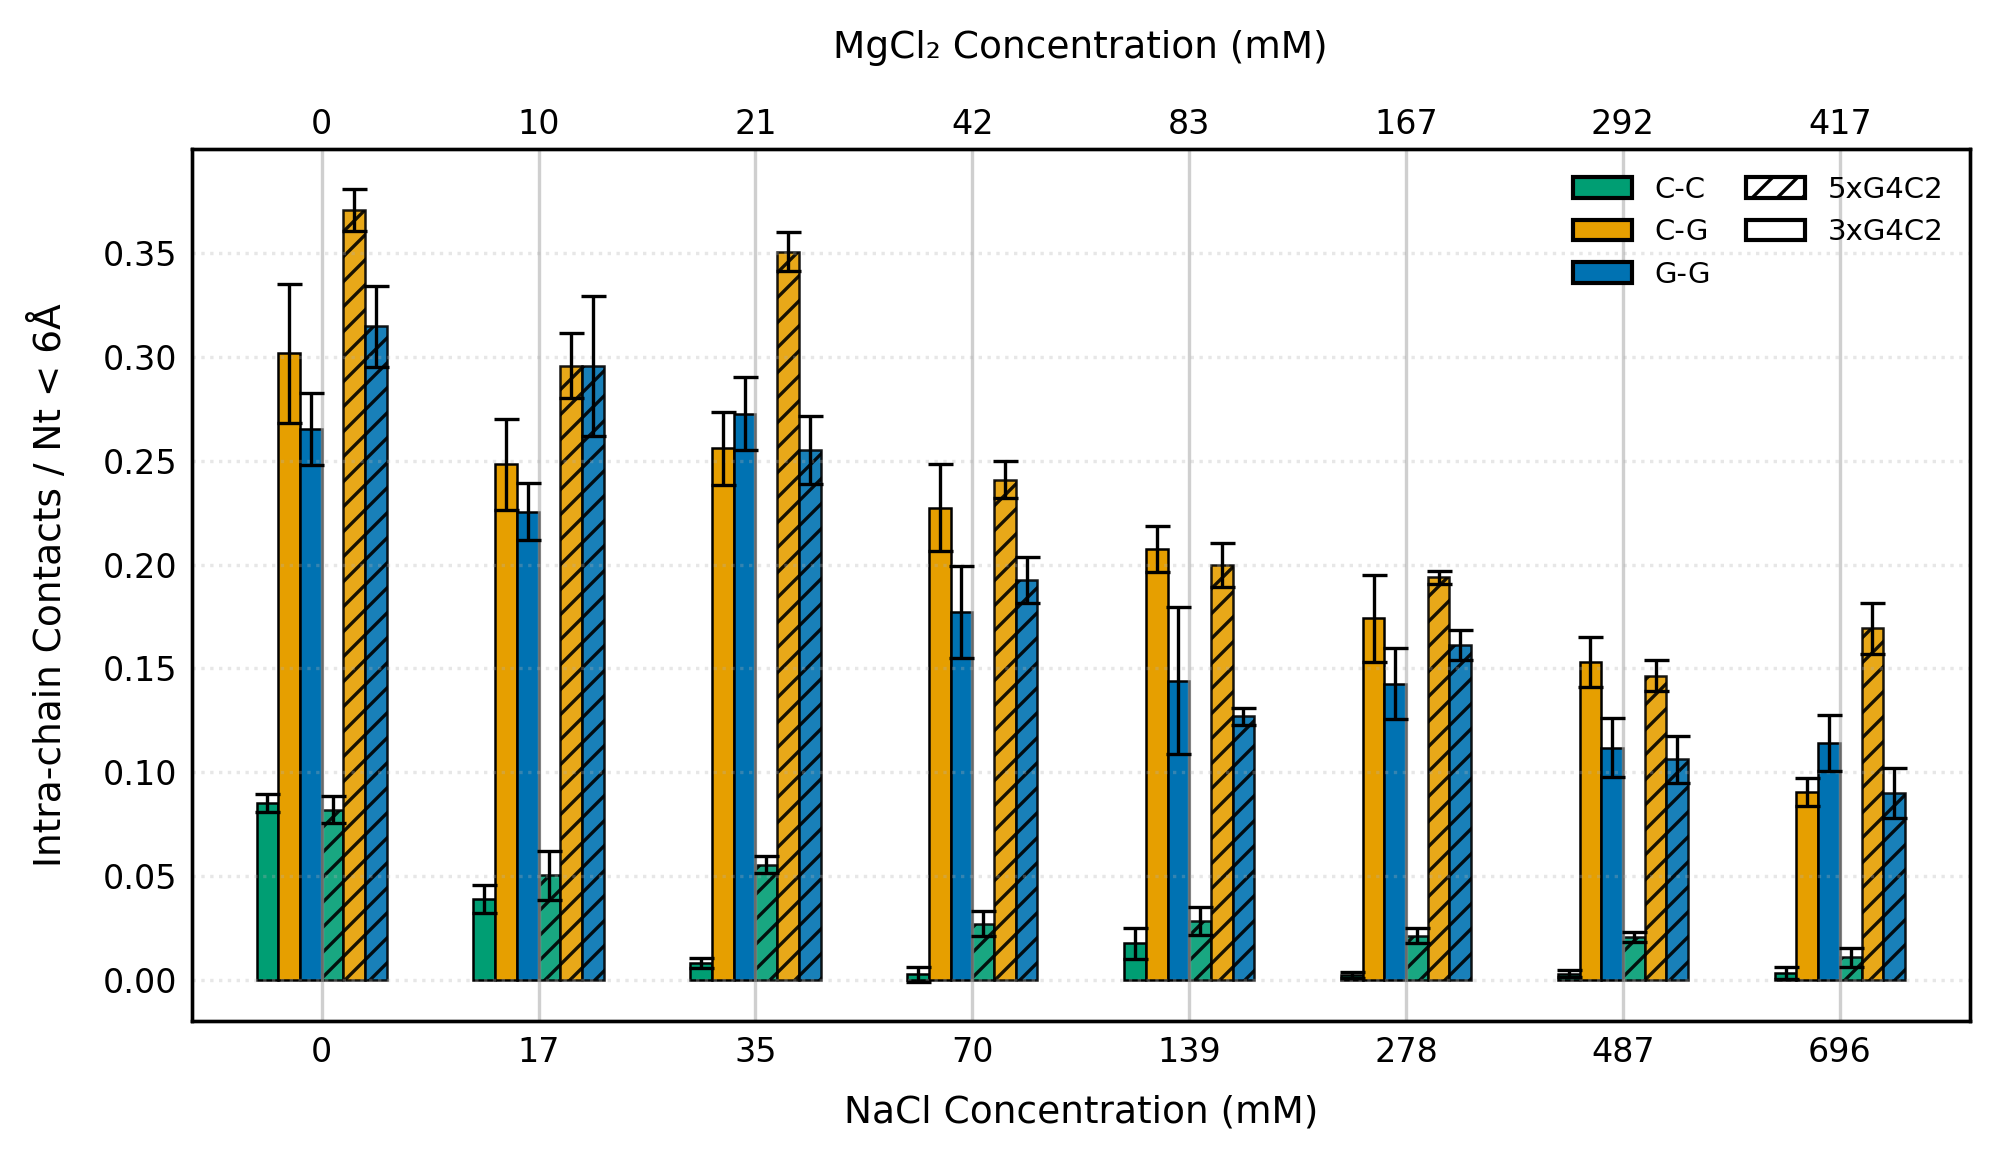

In [4]:
# %% Cell 3: Generate Normalized Contact Plot
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.ticker import MultipleLocator
from matplotlib import rcParams
rcParams.update({
    'font.sans-serif': 'DejaVu Sans',
    'font.size': 8,
    'axes.linewidth': 0.8,
    'xtick.major.width': 0.8,       
    'ytick.major.width': 0.8,       
    'xtick.minor.width': 0.6,       
    'ytick.minor.width': 0.6,       
    'axes.labelsize': 9,            
    'axes.titlesize': 9,            
    'legend.fontsize': 7,
    'figure.dpi': 300,
    'figure.figsize': (6.8, 4.0),   
    'savefig.dpi': 300,
    'hatch.linewidth': 0.8          })

# Color mapping for contact types (color-blind friendly)
COLOR_MAP = {
    'CC': '#009E73',  
    'CG': '#E69F00',  
    'GG': '#0072B2'   
}

fig, ax = plt.subplots()

nacl_ticks = np.array([0, 17, 35, 70, 139, 278, 487, 696])
mgcl2_ticks = np.array([0, 10, 21, 42, 83, 167, 292, 417])  # NaCl to MgCl2 conversion
x_pos = np.arange(len(nacl_ticks))
bar_width = 0.1

offset_dict = {
    '3xCC': -bar_width*2.5,
    '3xCG': -bar_width*1.5,
    '3xGG': -bar_width*0.5,
    '5xCC': bar_width*0.5,
    '5xCG': bar_width*1.5,
    '5xGG': bar_width*2.5
}  # Offset for grouped bars

# Normalize contacts by total number of nucleotides
chain_lengths = {
    '3xG4C2': 18*12,  # 18 nt per chain, 12 chains
    '5xG4C2': 30*12   # 30 nt per chain, 12 chains
}

norm1_data = np.zeros_like(plot_data)
for i in range(len(salt_order)):
    for j, sys in enumerate(['3xG4C2', '5xG4C2']):
        clen = chain_lengths[sys]
        for k in range(len(ctypes)):
            norm1_data[i,j,k,0] = plot_data[i,j,k,0] / clen  # Normalize mean
            norm1_data[i,j,k,1] = plot_data[i,j,k,1] / clen  # Normalize error
# Plot normalized data
for sidx in range(len(nacl_ticks)):

    # 3xG4C2 system (solid bars)
    for i, ct in enumerate(['CC', 'CG', 'GG']):
        if np.isnan(norm1_data[sidx, 0, i, 0]):
            continue
        offset = list(offset_dict.values())[i]
        mean, err = norm1_data[sidx, 0, i]
        ax.bar(x_pos[sidx] + offset, mean, bar_width,
               color=COLOR_MAP[ct], edgecolor='k', linewidth=0.6, 
               yerr=err, error_kw={'elinewidth': 0.8, 'capsize': 3, 'capthick': 0.8})  

    # 5xG4C2 system (hatched bars for contrast)
    for i, ct in enumerate(['CC', 'CG', 'GG']):
        if np.isnan(norm1_data[sidx, 1, i, 0]):
            continue
        offset = list(offset_dict.values())[i+3]
        mean, err = norm1_data[sidx, 1, i]
        ax.bar(x_pos[sidx] + offset, mean, bar_width,
               color=COLOR_MAP[ct], edgecolor='k', linewidth=0.6,
               hatch='////', alpha=0.9,
               yerr=err, error_kw={'elinewidth': 0.8, 'capsize': 3, 'capthick': 0.8})

# Configure axes and labels
ax.set_xlabel('NaCl Concentration (mM)', labelpad=6)  
ax.set_xlim(-0.6, len(nacl_ticks)-0.4)
# ax.set_ylim(-0.05, 1.1)
ax.set_xticks(x_pos)
ax.set_xticklabels(nacl_ticks, rotation=0, ha='center')
ax.tick_params(axis='x', length=0, bottom=False)

# Secondary x-axis for MgCl2 concentration
ax_top = ax.twiny()
ax_top.set_xlim(ax.get_xlim())
ax_top.set_xticks(x_pos)
ax_top.set_xticklabels(mgcl2_ticks, rotation=0, ha='center', va='bottom')  
ax_top.set_xlabel('MgCl₂ Concentration (mM)', labelpad=12)  
ax_top.tick_params(axis='x', length=0, pad=2)

ax.set_ylabel('Intra-chain Contacts / Nt < 6Å', labelpad=8) 
ax.tick_params(axis='both', which='major', length=0, width=0.8)  

legend_elements = [
    Patch(facecolor=COLOR_MAP['CC'], edgecolor='k', label='C-C'),
    Patch(facecolor=COLOR_MAP['CG'], edgecolor='k', label='C-G'),
    Patch(facecolor=COLOR_MAP['GG'], edgecolor='k', label='G-G'),
    Patch(facecolor='white', edgecolor='k', hatch='////', label='5xG4C2'),
    Patch(facecolor='white', edgecolor='k', label='3xG4C2')
]

ax.legend(handles=legend_elements, 
          loc='upper right', 
          ncol=2,
          frameon=False,
          handletextpad=0.8,      
          columnspacing=1.2)      
ax.xaxis.grid(True, which='major', linestyle='-', linewidth=0.8, alpha=0.6)
ax.yaxis.grid(True, which='major', linestyle=':', linewidth=0.8, alpha=0.3)

plt.tight_layout(pad=1.5)
plt.savefig('Figure4a_figureS5a.png', dpi=300, bbox_inches='tight')
plt.show()